In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
mostrecent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
mostrecent

('2017-08-23')

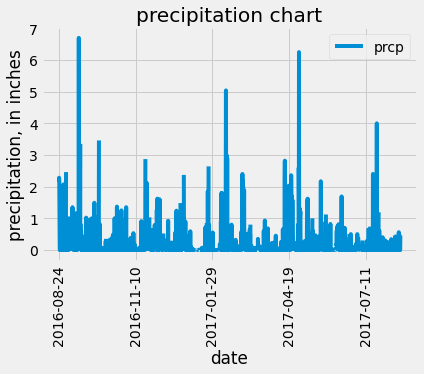

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
mostrecent
# Calculate the date one year from the last date in data set.
# https://docs.python.org/3/library/datetime.html
one_year_from = dt.date(2017, 8, 23) - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_from).all()
results
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results)
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_values('date', inplace=True)
df
# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.title('precipitation chart')
plt.xlabel("date")
plt.ylabel("precipitation, in inches")
plt.xticks(rotation = 90) 
plt.show()


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [17]:
stationcount = session.query(Station.station).count()
print(stationcount)
print('there are 9 stations in the data set')

9
there are 9 stations in the data set


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station,func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mintemp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').group_by(Measurement.station).all()

maxtemp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').\
group_by(Measurement.station).all()

avgtemp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').\
group_by(Measurement.station).all()

print(f'lowest temp for USC00519281 is {mintemp}')
print(f'highest temp for USC00519281 is {maxtemp}')
print(f'average temp for USC00519281 is {avgtemp}')

lowest temp for USC00519281 is [(54.0,)]
highest temp for USC00519281 is [(85.0,)]
average temp for USC00519281 is [(71.66378066378067,)]


<AxesSubplot:ylabel='Frequency'>

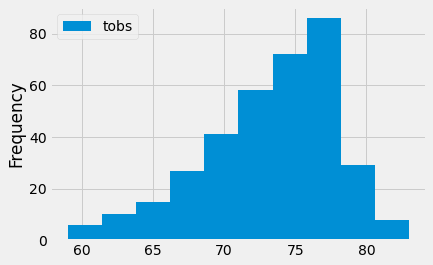

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).all()
station_df = pd.DataFrame(query, columns=['date', 'tobs'])
station_df.plot.hist()

# Close session

In [21]:
# Close Session
session.close()